In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [7]:
from proj1_helpers import *
import zipfile
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
zf = zipfile.ZipFile('../data/test.csv.zip')
zf.extract('test.csv', path='../data')
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Do your thing crazy machine learning thing here :) ...

### Exploratory data analysis

In [14]:
miss_values_tr = len(tX[tX==-999])
miss_values_te = len(tX_test[tX_test==-999])
print('There are {a} data points and {b} features in the training data.'.format(a=tX.shape[0], b=tX.shape[1]))
print('There are {a} missing values for a total number of {b} values in the training data. -> {c}% are missing values'.format(a=miss_values_tr, b=tX.shape[0]*tX.shape[1], c = 100*miss_values_tr/(tX.shape[0]*tX.shape[1])))
print('There are {a} missing values for a total number of {b} values in the test data. -> {c}% are missing values'.format(a=miss_values_te, b=tX_test.shape[0]*tX_test.shape[1], c = 100*miss_values_te/(tX_test.shape[0]*tX_test.shape[1])))

There are 250000 data points and 30 features in the training data.
There are 1580052 missing values for a total number of 7500000 values in the training data. -> 21.06736% are missing values
There are 3588434 missing values for a total number of 17047140 values in the test data. -> 21.050064702935508% are missing values


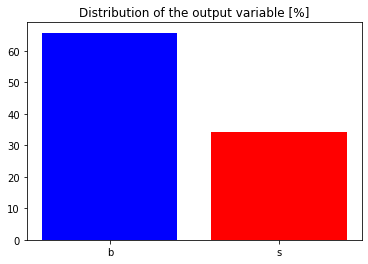

In [9]:
s = np.sum(y)
b = len(y) - s
tot = len(y)
labels =  [(b/tot)*100, (s/tot)*100]
plt.bar(['b', 's'], labels, color = ['b', 'r'])
plt.title("Distribution of the output variable [%]")
plt.show()

### Preprocessing

In [4]:
from data_processing import*
train_tx, train_y, val_tx, val_y, test_tx, test_y = preprocessing(tX, y, tX_test, y_test)

### Cross-validation

Parameters definition for all the cross validations and spliting of the data in k (=?) folds

In [5]:
from cross_validation import*

seed = 1
k_fold = 5

max_iters = [50, 100, 150, 200]
gammas = np.logspace(-4, 0, 30)
lambdas = np.logspace(-4, 0, 30)

# split data in k fold
k_indices = build_k_indices(train_y, k_fold, seed)

#### Gradient descent

In [6]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_GD(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [7]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.8252323228470028. max_iter = 200, gamma = 0.2807216203941176. 
minimum test rmse: 0.8252297451807662. max_iter = 200, gamma = 0.2807216203941176. 
maximum train accuracy: 0.7441314285714287. max_iter = 200, gamma = 0.2807216203941176. 
maximum test accuracy: 0.7441314285714287. max_iter = 200, gamma = 0.2807216203941176. 


#### Stochastic Gradient Descent

In [8]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_SGD(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [9]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.901986001541729. max_iter = 200, gamma = 0.006210169418915616. 
minimum test rmse: 0.9016239916555812. max_iter = 200, gamma = 0.006210169418915616. 
maximum train accuracy: 0.7028085714285714. max_iter = 200, gamma = 0.006210169418915616. 
maximum test accuracy: 0.7020799999999999. max_iter = 200, gamma = 0.006210169418915616. 


#### Ridge regression

In [10]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros(len(gammas))
rmse_te = np.zeros(len(gammas))
acc_tr = np.zeros(len(gammas))
acc_te = np.zeros(len(gammas))
# compute loss for each lambda is lambdas
for i, lambda_ in enumerate(lambdas):
    rmse_tr_tmp = []
    rmse_te_tmp = []
    acc_tr_tmp = []
    acc_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, accuracy = cv_ridge_regression(train_y, train_tx, k_indices, k, lambda_)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
        acc_tr_tmp.append(accuracy[0])
        acc_te_tmp.append(accuracy[1])


    rmse_tr[i] = np.mean(rmse_tr_tmp)
    rmse_te[i] = np.mean(rmse_te_tmp)
    acc_tr[i] = np.mean(acc_tr_tmp)
    acc_te[i] = np.mean(acc_te_tmp)

In [11]:
# Index of min/max error/accuracy
i_rmse_tr = rmse_tr.argmin()
i_rmse_te = rmse_te.argmin()
i_acc_tr = acc_tr.argmax()
i_acc_te = acc_te.argmax()

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr]
rmse_te_min = rmse_te[i_rmse_te]
acc_tr_max = acc_tr[i_acc_tr]
acc_te_max = acc_te[i_acc_te]

# Print results
print('minimum train rmse: {rmse_tr_min}. gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, g = lambdas[i_rmse_tr]))
print('minimum test rmse: {rmse_te_min}. gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, g = lambdas[i_rmse_te]))
print('maximum train accuracy: {acc_tr_max}. gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, g = lambdas[i_acc_tr]))
print('maximum test accuracy: {acc_te_max}. gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, g = lambdas[i_acc_te]))

minimum train rmse: 0.8252125366736497. gamma = 0.0001. 
minimum test rmse: 0.8254032924957986. gamma = 0.00018873918221350977. 
maximum train accuracy: 0.7442528571428572. gamma = 0.00018873918221350977. 
maximum test accuracy: 0.74424. gamma = 0.0001. 


#### Logistic regression

In [15]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_logistic_regression(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [16]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 550.5250469484163. max_iter = 50, gamma = 0.0001. 
minimum test rmse: 550.5212527567351. max_iter = 50, gamma = 0.0001. 
maximum train accuracy: 0.7138571428571427. max_iter = 50, gamma = 0.0001. 
maximum test accuracy: 0.7138571428571427. max_iter = 50, gamma = 0.0001. 


#### Regularized logistic regression

In [ ]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
rmse_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        for k, lambda_ in enumerate(lambdas):
            rmse_tr_tmp = []
            rmse_te_tmp = []
            acc_tr_tmp = []
            acc_te_tmp = []
            for k in range(k_fold):
                loss_tr, loss_te, accuracy = cv_reg_logistic_regression(train_y, train_tx, k_indices, k, lambda_, max_iter, gamma)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
                acc_tr_tmp.append(accuracy[0])
                acc_te_tmp.append(accuracy[1])


            rmse_tr[i, j, k] = np.mean(rmse_tr_tmp)
            rmse_te[i, j, k] = np.mean(rmse_te_tmp)
            acc_tr[i, j, k] = np.mean(acc_tr_tmp)
            acc_te[i, j, k] = np.mean(acc_te_tmp)

In [ ]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1], i_rmse_tr[2]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1], i_rmse_te[2]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1], i_acc_tr[2]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1], i_acc_te[2]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]], l = lambdas[i_rmse_tr[2]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]], l = lambdas[i_rmse_te[2]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]], l = lambdas[i_acc_tr[2]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]], l = lambdas[i_acc_te[2]]))

## Generate predictions and save ouput in csv format for submission:

In [31]:
OUTPUT_PATH = '../data/sample-submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)